# Find the ellipse

This is the first version of the code, which can find ellipses in the images
The code uses the principles of Hough transform in the most general form, but allows to tweak the size of the
Hough space to make the code efficient.

Main principle of Hough transform. Each ellipse is defined by 5 parameters: 

x,y - center coordinates, 

a,b -  major and minor half-axes, 

th - large angle axis with respect to the x axis.

The Hough space is a 5-dimensional array corresponding to all possible values of all five paramters. The algorithm counts how many points are located on each of the ellipses included in the Hough space within a certain tolerance. The ellipses with the largest score (the largest number of points) are then selected, taking into account that their centers should lie a certain distance away. 

To save on computation time, the image is processes do leave only contours of the eggs visible using image processing like thresholding and Canny edge detection. The step size in the Hough space should not be too precise. 

If more precision is needed, one can start with a rough search and then refine the search around the set of parameters found in the first step (not implemented here).

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as pl
import time

In [362]:
# this function sets up the hough space and the arrays for all ellipse parameters. As inputs, it takes 
# tuples or lists of three elements: starting value, ending value and number of points.
# x, y - center coordinates
# a, b - half-axes
# th - angle
# Return values:
# x_vec, y_vec, etc - arrays of the parameters
# R_mat - a list of rotation matrices corresponding to the angles in th_vec
# hough_mat - Hough space initialized with zeros
def hough_space(x, y, a, b, th):
    th_vec = np.linspace(th[0],th[1],th[2])
    R_mat=[]
    for i in range(0,len(th_vec)):
        c=np.cos(th_vec[i])
        s=np.sin(th_vec[i])
        R_mat.append(np.array([[c,s],[-s,c]]))
    a_vec = np.linspace(a[0],a[1],a[2])
    b_vec = np.linspace(b[0],b[1],b[2])
    x_vec = np.linspace(x[0],x[1],x[2])
    y_vec = np.linspace(y[0],y[1],y[2])
    hough_mat = np.zeros((x[2],y[2],a[2],b[2],th[2]))
    return x_vec, y_vec, a_vec, b_vec, th_vec, R_mat, hough_mat
    #return {'th_vec':th_vec, 'R_mat':R_mat, 'a_vec':a_vec, 'b_vec':b_vec, 'x_vec':x_vec, 'y_vec':y_vec, 'hough_mat':hough_mat}

In [3]:
# obsolete function, used with the slow hough_find()
def hough_hit(x1,y1,x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat,tol):
    for th in range(0,len(th_vec)):
        for a in range(0,len(a_vec)):
            for b in range(0,len(b_vec)):
                for x in range(0,len(x_vec)):
                    for y in range(0,len(y_vec)):
                        dx = x1-x_vec[x]
                        dy = y1-y_vec[y]
                        (dx1,dy1) = R_mat[th].dot([dx, dy])
                        if (dx1!=0):
                            th1 = np.arctan(a_vec[a]/b_vec[b]*dy1/dx1)
                        else:
                            th1 = np.pi/2.*np.sign(dy1)
                        dx2 = a_vec[a] * np.cos(th1)
                        dy2 = b_vec[b] * np.sin(th1)
                        if ((dx2-dx1)**2+(dy2-dy1)**2<tol):
                            hough_mat[x,y,a,b,th] += 1

In [4]:
# obsolete, slow version of hough_find
def hough_find(img,x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat, tol, maxpt):
    # cycle through all points
    (y,x)=np.nonzero(img)
    if (len(x)>maxpt):
        through(1)
    for i in range(0,len(x)):
        hough_hit(x[i],y[i],x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat,tol)
    return

In [363]:
# ranks all ellipses in the Hough space by assigning scores in hough_mat
# tol - square tolerance, e.g. 4 corrsponds to a distane of 2 pixels
# maxpt - checks that not too many points are present in the image
# img - image with non-zero pixels to be used to find ellipses
# the function modifies the hough_mat in place (reinitialize to recalculate!)
def hough_find1(img,x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat, tol, maxpt):
    # find all non-zero points
    (y1,x1)=np.nonzero(img)
    # fail if there are too many points
    if (len(x1)>maxpt):
        through(1)
    # loop through ellipse center coordinates
    for x in range(0,len(x_vec)):
        for y in range(0,len(y_vec)):
            # dispacement of all points from the current ellipse center
            dx = x1-x_vec[x]
            dy = y1-y_vec[y]
            # loop through all angles
            for th in range(0,len(th_vec)):
                # rotate all points to get coordinates with respect to ellipse's main axis
                (dx1,dy1) = R_mat[th].dot([dx, dy])
                # prepare the array of angles parametrizing the ellipse
                th1 = np.ones(np.shape(dx1))*np.pi/2.*np.sign(dy1)
                th_ind=(dx1!=0)
                dy1_dx1=dy1[th_ind]/dx1[th_ind]
                for a in range(0,len(a_vec)):
                    for b in range(0,len(b_vec)):
                        # get parametric ellipse angles
                        th1[th_ind] = np.arctan(a_vec[a]/b_vec[b]*dy1_dx1)
                        # calculate the corresponding coordinates on the ellipse
                        dx2 = a_vec[a] * np.cos(th1)
                        dy2 = b_vec[b] * np.sin(th1)
                        # for all points within the tolerance to ellipse points, add one to the score
                        hough_mat[x,y,a,b,th] += np.sum((dx2-dx1)**2+(dy2-dy1)**2<tol)
    return       

In [364]:
# get number n of ellipses with the maximum score, with centers are separated by no less than R points
# returns a list of tuples of five indeces corresponding to the five paramteres x,y,a,b,th
def hough_get_max(hough_mat,x_vec,y_vec,n,R):
    hm = hough_mat.copy()
    ind=[]
    x=np.array([])
    y=np.array([])
    num=0
    while (num<n and np.max(hm)>0):
        i = np.unravel_index(np.argmax(hm),np.shape(hm))
        # if the first ellipse or ellipse R points far away from all others
        if (len(ind)==0 or ((x_vec[i[0]]-x)**2+(y_vec[i[1]]-y)**2>R**2).all()):
            ind.append(i)
            x=np.append(x,x_vec[i[0]])
            y=np.append(y,y_vec[i[1]])
            num+=1
        hm[i]=0
    return ind

In [7]:
# this function draws ellipse, not used 
def hough_draw_ellipse(img,x,y,a,b,th0,val):
    th=np.linspace(0,2*np.pi,int(2*round(2*np.pi*a)))
    c=np.cos(th0)
    s=np.sin(th0)
    R=np.array([[c,-s],[s,c]])
    for t in th:
        x1=a*np.cos(t)
        y1=b*np.sin(t)
        (x1,y1)=R.dot([x1,y1])
        x1=int(round(x1+x))
        y1=int(round(y1+y))
        if (x1>=0 and y1>=0 and x1<np.shape(img)[1] and y1<np.shape(img)[0]):
            img[y1,x1]=val

# Test the code

In [70]:
img=np.zeros((100,100))
hough_draw_ellipse(img,50,50,10,4,-np.pi/6,1)
#img=cv2.ellipse(img,(50,50),(10,4),0,0,360,1)
np.sum(img)

56.0

In [88]:
start=time.time()
(x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat)=hough_space([45,55,11],[45,55,11],[8,12,5],[3,5,3],[-np.pi/2,np.pi/2,17])
hough_find1(img, x_vec,y_vec,a_vec,b_vec,th_vec,R_mat,hough_mat, 1, 100)
end=time.time()
print(end-start)

0.5547995567321777


In [91]:
ind=hough_get_max(hough_mat,x_vec,y_vec,1,10)
ind=ind[0]
x=x_vec[ind[0]]
y=y_vec[ind[1]]
a=a_vec[ind[2]]
b=b_vec[ind[3]]
th=th_vec[ind[4]]
hough_draw_ellipse(img,x+1,y,a,b,th,0.5)

In [92]:
x,y,a,b,th,ind

(49.0, 50.0, 11.0, 4.0, -0.39269908169872414, (4, 5, 3, 1, 6))

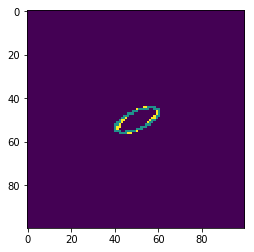

In [93]:
pl.figure()
pl.imshow(img)

# Test on images with eggs

In [373]:
#cap = cv2.VideoCapture('c:/Users/kornilov/Physics/Results/IZW_Embrioscope2021/D2021.08.05_2week.avi')
cap = cv2.VideoCapture('/home/kornilov/Physics/Results/IZW_Embrioscope2021/D2021.08.05_2week.avi')
ret, frame = cap.read() # read first frame in the sequence
img=frame[:,:,0][200:400,0:200] # the frame has 16 images 200x200 each, take only one channel

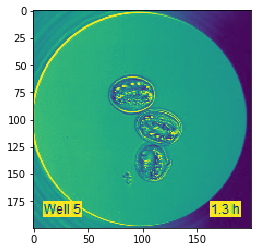

In [374]:
pl.figure()
pl.imshow(img)

In [375]:
# image pre-processing
# radius of the Petri dish
maxR=90
# coordinate and radial matrices
nx,ny=np.shape(img)
XX,YY=np.meshgrid(range(nx),range(ny))
RR2=(XX-nx/2)**2+(YY-ny/2)**2
# correct for a linear slope along the X axis
Xslope = 0.2
img=np.array(img+XX*Xslope,dtype='uint8')
# cut out areas outside of the Petri dish
img[RR2>maxR**2]=0

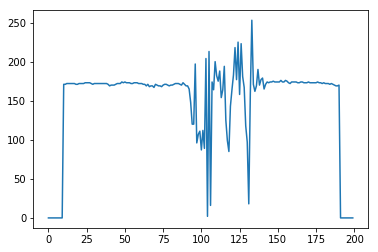

In [376]:
pl.figure()
pl.plot(img[100,:])

In [380]:
# normalize the image
img_t=img.copy()
img_t=img_t/np.max(img_t)
# the eggs are visible as a phase contrast. There fore both points much darker and much brighter than the 
# background belong to the eggs. Use points below the lower threshold and above the upper threshold
Uthr = 0.7 # upper threshold
Lthr = 0.55 # lower threshold
img_t=np.array((img_t>Uthr) | (img_t<Lthr),dtype='uint8')
img_t[img==0]=0 # still zero where it was zeroed

# slightly blur to remove single point noise
edges=cv2.blur(img_t,(2,2))
# Canny edge detection
edges=cv2.Canny(image=edges,threshold1=3,threshold2=5.5)

In [381]:
# to reduce the search one can define a bounding box
# to get rid of noise, blur the image by 10 points and find the area where intensity is not blurred away
bnd=cv2.boundingRect(np.array(cv2.blur(img_t,(10,10))>=0.99,dtype='uint8'))
bnd

(70, 59, 66, 98)

In [383]:
# number of points in the resulting contour image
# should not be too big, speed scales linearly with this (I think)
np.sum(edges/np.max(edges))

452.0

In [389]:
# define average expected values of major and minr half-axes
a=22
b=15
# define the boundary box
bx1=bnd[0]
bx2=bnd[0]+bnd[2]
by1=bnd[1]
by2=bnd[1]+bnd[3]
# initialize the Hough space: length paramteres are spaced by 2 points, angle is limited to 17 values
hs=hough_space([bx1,bx2,(bx2-bx1)//2+1],[by1,by2,(by2-by1)//2+1],[a-2,a+2,3],[b-2,b+2,3],[-np.pi/2,np.pi/2,17])
# find all ellipses with tolerance
hough_find1(edges,*hs,0.1,2000)

In [390]:
# indices of three ellipses, space no lass than minor half-axis
ind=hough_get_max(hs[6],hs[0],hs[1],3,b)
ind

[(10, 8, 1, 2, 8), (24, 24, 0, 2, 11), (20, 37, 2, 2, 15)]

In [391]:
# plotting
edges4=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
edges5=cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
cv2.rectangle(edges4,(bx1,by1),(bx2,by2),(0,255,0))
for i in ind:
    cv2.ellipse(edges4,(int(hs[0][i[0]]),int(hs[1][i[1]])),(int(hs[2][i[2]]),int(hs[3][i[3]])),hs[4][i[4]]/np.pi*180,0.,360.,(255,0,0))
    cv2.ellipse(edges5,(int(hs[0][i[0]]),int(hs[1][i[1]])),(int(hs[2][i[2]]),int(hs[3][i[3]])),hs[4][i[4]]/np.pi*180,0.,360.,(255,0,0))

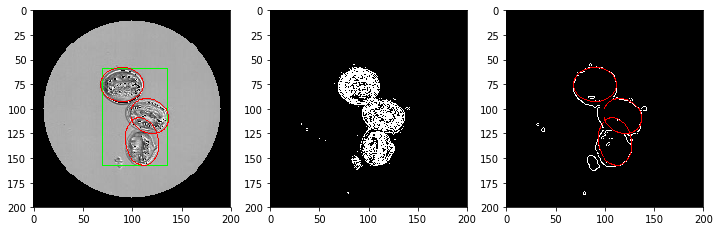

In [392]:
# plotting
pl.figure(figsize=(12,6))
pl.subplot(1,3,1)
pl.imshow(edges4,cmap='gray')
pl.subplot(1,3,2)
pl.imshow(img_t,cmap='gray')
pl.subplot(1,3,3)
pl.imshow(edges5,cmap='gray')

sampling down, keep just in case

In [ ]:
n=5
edges3=edges2.reshape(-1,n,edges2.shape[0]//n,n).sum((-1,-3))/n
edges3=np.array(edges3>0,dtype='uint8')